<a href="https://colab.research.google.com/github/arthurcaique/curso_verao_uninabuco/blob/master/sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from string import punctuation

import itertools
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_downloader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     train_test_split)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support)

nltk_downloader('punkt')
nltk_downloader('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
eng_stop_words = stopwords.words('english')

In [0]:
def pre_process_text(text: str):
  text = text.lower()
  return ' '.join([token for token in word_tokenize(text) 
                   if token not in punctuation and token not in eng_stop_words]).strip()

In [4]:
train_df = read_csv('train.tsv', sep = '\t', encoding='utf-8')
print(train_df.shape)

train_df.drop_duplicates(subset='SentenceId', keep='first', inplace=True)
print(train_df.shape)

X = train_df['Phrase'].apply(
    lambda phrase: pre_process_text(phrase))

train_df['Sentiment'] = train_df['Sentiment'].apply(
    lambda x: x if x not in [0, 3] else 1 if x == 0 else 4)

y = train_df['Sentiment'].values

(8529, 5)
(8529, 5)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, test_size=0.33, 
                                                    random_state=42)

In [0]:
vectorizer = TfidfVectorizer(max_features=10000)
tf_idf_matrix = vectorizer.fit_transform(X_train)

In [0]:
param_grid = {'n_estimators': [50, 100], 'class_weight': ['balanced', None]}

rf_classifier = RandomForestClassifier(random_state=1)

grid_search_model = GridSearchCV(
    estimator=rf_classifier, param_grid=param_grid, cv=3)

In [8]:
grid_search_model.fit(tf_idf_matrix, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
vectorized_test = vectorizer.transform(X_test)
predictions = grid_search_model.predict(vectorized_test)

In [0]:
conf_mat = confusion_matrix(y_true = y_test, y_pred = predictions, labels = list(set(y_train)))

Confusion matrix, without normalization
[[690 111 282]
 [226  77 229]
 [282  86 832]]


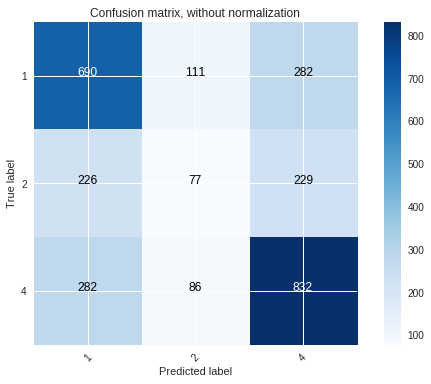

In [19]:
plt.figure()
plot_confusion_matrix(conf_mat, classes=list(set(y_train)),
                      title='Confusion matrix, without normalization')

In [23]:
precision_recall_fscore_support(y_true=y_test, y_pred=predictions, labels = list(set(y_train)), average='weighted')

(0.5387845587272143, 0.5680284191829484, 0.5478062460119738, None)

In [24]:
precision_recall_fscore_support(y_true=y_test, y_pred=predictions, labels = list(set(y_train)))

(array([0.57595993, 0.2810219 , 0.61950856]),
 array([0.63711911, 0.14473684, 0.69333333]),
 array([0.60499781, 0.191067  , 0.65434526]),
 array([1083,  532, 1200]))